In [8]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks
from tensorflow.keras import initializers

from tensorflow.keras.datasets import mnist

# 1D

In [9]:
def load_data(dataset):
    if dataset == "mnist":
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
    else:
        x_train = np.load("Data/" + dataset + ".npy")
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    x_train = x_train.reshape(len(x_train), 784)
    return (x_train)

In [10]:
def build_1D_generator(rand_shape, output_shape):
    
    data_in = Input(shape=rand_shape, name="data_in")
    
    x = Dense(256, kernel_initializer=initializers.RandomNormal(stddev=0.02))(data_in)       
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Dense(512)(x)       
    x = LeakyReLU(alpha=0.2)(x)

    x = Dense(1024)(x)       
    x = LeakyReLU(alpha=0.2)(x)

    out = Dense(output_shape[0], activation='tanh')(x)
    
    generator = Model(inputs=[data_in], outputs=[out])
    generator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    generator.summary()
    return generator

In [11]:
def build_1D_discriminator(input_shape):
    
    data_in = Input(shape=input_shape, name="data_in")
    
    x = Dense(1024, kernel_initializer=initializers.RandomNormal(stddev=0.02))(data_in)       
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)
    
    x = Dense(512)(x)       
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Dense(256)(x)       
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    out = Dense(1, activation='sigmoid')(x)
    
    discriminator = Model(inputs=[data_in], outputs=[out])
    discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    discriminator.summary()
    return discriminator

In [12]:
def build_gan(generator, discriminator, rand_shape):
    
    # set generation mode
    discriminator.trainable = False
    
    gan_input = Input(shape=rand_shape)
    x = generator(gan_input)
    gan_output = discriminator(x)
    
    gan = Model(inputs=[gan_input], outputs=[gan_output])
    gan.compile(loss="binary_crossentropy", optimizer="adam")
    
    return gan

In [13]:
def train_gan(dataset, rand_param_size=100, epochs=10, batch_size=32, show_img=True):
    np.random.seed(10)
    # Load data
    x_train = load_data(dataset)
    # Set shapes and stuff
    rand_shape = (rand_param_size, )
    output_shape = x_train.shape[1:]
    batch_count = int(x_train.shape[0] / batch_size)

    # Build models
    generator = build_1D_generator(rand_shape, output_shape)
    discriminator = build_1D_discriminator(output_shape)
    gan = build_gan(generator, discriminator, rand_shape)

    # Train for each epoch
    for i in range(1, epochs + 1):
        print('-'*15, 'Epoch %d' % i, '-'*15)
        # for each batch
        for j in tqdm(range(batch_count)):
            # build fake image
            noise = np.random.normal(0, 1, size=[batch_size, rand_param_size])
            generated_images = generator.predict(noise)
            # grab real images
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
            # Build mixed dataset
            X = np.concatenate([image_batch, generated_images])
            # Build labels
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9
            # Discriminator train step
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)
            # Build new seeds and "real" labels
            seeds = np.random.normal(0, 1, size=[batch_size, rand_param_size])
            y_gen = np.ones(batch_size)
            # Generator train step
            discriminator.trainable = False
            g_loss = gan.train_on_batch(seeds, y_gen)
        print("D_loss = %s ; G_loss = %s" % (d_loss, g_loss))
        if show_img:
            # build fake images
            visu_seeds = np.random.normal(0, 1, size=[batch_size, rand_param_size])
            built_images = generator.predict(visu_seeds)
            built_images = built_images.reshape(built_images.shape[0], int(np.sqrt(built_images.shape[1])), int(np.sqrt(built_images.shape[1])))
            # plot generated images
            fig = plt.figure(figsize=(8, 8))
            columns = 4
            rows = batch_size / columns
            for i, img in enumerate(built_images):
                if i + 1 > 0 and i < columns * rows:
                    fig.add_subplot(rows, columns, i+1)
                    plt.imshow(img, cmap="Greys")
            plt.show()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_in (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 1024)              0   

  0%|          | 1/1875 [00:00<05:53,  5.31it/s]

--------------- Epoch 1 ---------------


100%|██████████| 1875/1875 [03:12<00:00,  9.73it/s]


D_loss = [0.16361453, 0.5] ; G_loss = 15.147186


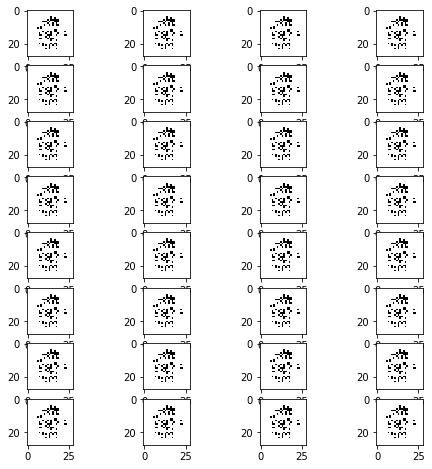

  0%|          | 1/1875 [00:00<03:23,  9.20it/s]

--------------- Epoch 2 ---------------


  8%|▊         | 158/1875 [00:16<03:04,  9.30it/s]

KeyboardInterrupt: 

In [14]:
train_gan("mnist", rand_param_size=100, epochs=10, batch_size=32, show_img=True)

# 2D

In [2]:
def load_2D_data(dataset):
    if dataset == "mnist":
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
    else:
        x_train = np.load("Data/" + dataset + ".npy")
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    if len(x_train.shape) < 4:
        x_train = np.expand_dims(x_train, axis=3)
    return (x_train)

In [3]:
def build_2D_generator(rand_shape, output_shape, width):
    
    data_in = Input(shape=rand_shape, name="data_in")
    
    x = Dense(output_shape[0] * output_shape[1] * output_shape[2], 
              kernel_initializer=initializers.RandomNormal(stddev=0.02))(data_in)       
    x = LeakyReLU(alpha=0.2)(x)

    x = Reshape(output_shape)(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(width // 2, 5, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(width // 4, 5, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(width // 8, 5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
     
    out = Conv2D(1, 5, strides=2, padding='same', activation="tanh")(x)
    
    generator = Model(inputs=[data_in], outputs=[out])
    generator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    generator.summary()
    return generator

In [4]:
def build_2D_discriminator(input_shape, width):
    
    data_in = Input(shape=input_shape, name="data_in")

    x = Conv2D(filters=width, kernel_size=depth // 2, strides=2,
                padding='same', activation="relu", use_bias=False, 
                kernel_initializer=initializers.RandomNormal(stddev=0.02))(data_in)       
    x = BatchNormalization()(x)

    x = Conv2D(filters=width // 2, kernel_size=depth // 4, strides=2, padding='same', 
                      activation="relu", use_bias=False)(x)       
    x = BatchNormalization()(x)

    x = Conv2D(filters=width // 4, kernel_size=depth // 8, strides=2, padding='same', 
                      activation="relu", use_bias=False)(x)       
    x = BatchNormalization()(x)

    x = Flatten(name='flattened')(x)

    out = Dense(1, activation='sigmoid')(x)
    
    discriminator = Model(inputs=[data_in], outputs=[out])
    discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    discriminator.summary()

    return discriminator

In [5]:
def build_2D_gan(generator, discriminator, rand_shape):
    
    # set generation mode
    discriminator.trainable = False
    
    gan_input = Input(shape=rand_shape)
    x = generator(gan_input)
    gan_output = discriminator(x)
    
    gan = Model(inputs=[gan_input], outputs=[gan_output])
    gan.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
    
    return gan

In [6]:
def train_2D_gan(dataset, rand_param_size=100, width=64, epochs=10, batch_size=32, show_img=True):
    np.random.seed(10)
    # Load data
    x_train = load_2D_data(dataset)
    # Set shapes and stuff
    rand_shape = (rand_param_size, )
    output_shape = x_train.shape[1:]
    batch_count = int(x_train.shape[0] / batch_size)

    # Build models
    generator = build_2D_generator(rand_shape, output_shape, width)
    discriminator = build_2D_discriminator(output_shape, width)
    gan = build_2D_gan(generator, discriminator, rand_shape)

    # Train for each epoch
    for i in range(1, epochs + 1):
        print('-'*15, 'Epoch %d' % i, '-'*15)
        # for each batch
        for j in tqdm(range(batch_count)):
            # build fake image
            noise = np.random.normal(0, 1, size=[batch_size, rand_param_size])
            generated_images = generator.predict(noise)
            # grab real images
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
            # Build mixed dataset
            X = np.concatenate([image_batch, generated_images])
            # Build labels
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9
            # Discriminator train step
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)
            # Build new seeds and "real" labels
            seeds = np.random.normal(0, 1, size=[batch_size, rand_param_size])
            y_gen = np.ones(batch_size)
            # Generator train step
            discriminator.trainable = False
            g_loss = gan.train_on_batch(seeds, y_gen)
        print("D_loss = %s ; G_loss = %s" % (d_loss, g_loss))
        if show_img:
            # build fake images
            visu_seeds = np.random.normal(0, 1, size=[batch_size, rand_param_size])
            built_images = generator.predict(visu_seeds)
            print(built_images.shape)
            built_images = built_images.reshape(built_images.shape[0], built_images.shape[1], built_images.shape[2])
            # plot generated images
            fig = plt.figure(figsize=(8, 8))
            columns = 4
            rows = batch_size / columns
            for i, img in enumerate(built_images):
                if i + 1 > 0 and i < columns * rows:
                    fig.add_subplot(rows, columns, i+1)
                    plt.imshow(img, cmap="Greys")
            plt.show()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_in (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 784)               79184     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 784)               0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 56, 56, 1)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 56, 56, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 56, 32)        128   

  0%|          | 0/937 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


100%|██████████| 937/937 [02:01<00:00,  7.71it/s]


D_loss = [0.405191, 0.4921875] ; G_loss = 1.5957928
(64, 28, 28, 1)


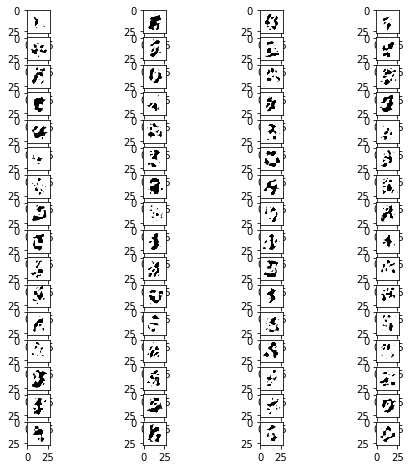

  0%|          | 1/937 [00:00<02:14,  6.96it/s]

--------------- Epoch 2 ---------------


100%|██████████| 937/937 [01:58<00:00,  7.88it/s]


D_loss = [0.16485372, 0.5] ; G_loss = 0.1295295
(64, 28, 28, 1)


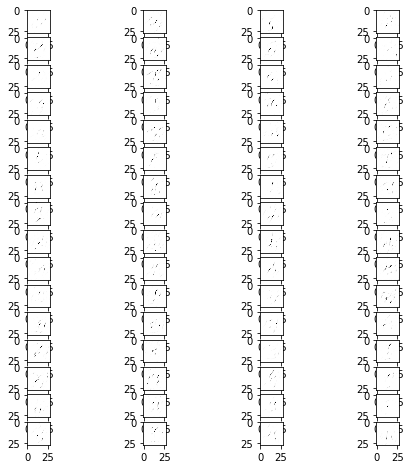

  0%|          | 1/937 [00:00<02:14,  6.96it/s]

--------------- Epoch 3 ---------------


100%|██████████| 937/937 [02:02<00:00,  7.66it/s]


D_loss = [0.2355847, 0.4921875] ; G_loss = 4.366212
(64, 28, 28, 1)


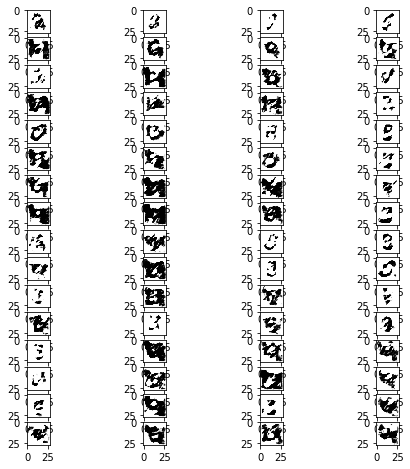

  0%|          | 1/937 [00:00<02:20,  6.64it/s]

--------------- Epoch 4 ---------------


100%|██████████| 937/937 [02:01<00:00,  7.74it/s]


D_loss = [0.1631861, 0.5] ; G_loss = 5.533793
(64, 28, 28, 1)


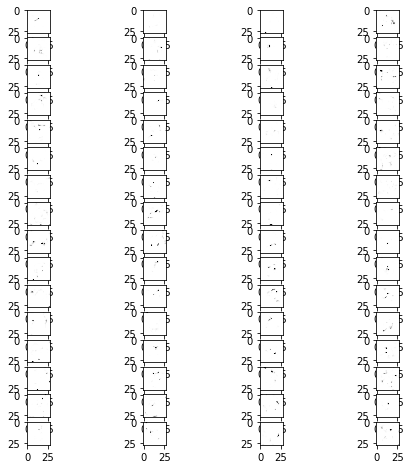

  0%|          | 1/937 [00:00<02:11,  7.11it/s]

--------------- Epoch 5 ---------------


100%|██████████| 937/937 [02:01<00:00,  7.69it/s]


D_loss = [0.3179795, 0.484375] ; G_loss = 5.3594265
(64, 28, 28, 1)


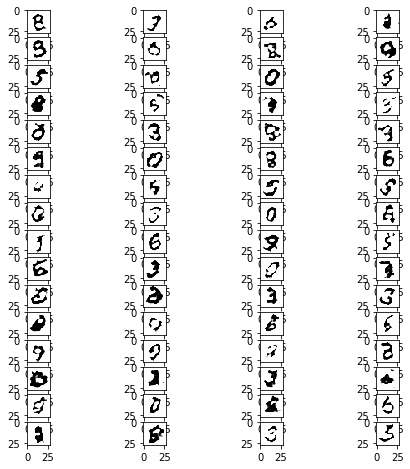

  0%|          | 1/937 [00:00<02:14,  6.96it/s]

--------------- Epoch 6 ---------------


100%|██████████| 937/937 [02:06<00:00,  7.42it/s]


D_loss = [0.3065219, 0.5] ; G_loss = 4.049284
(64, 28, 28, 1)


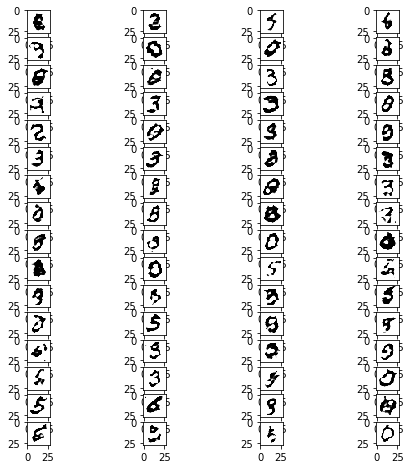

  0%|          | 1/937 [00:00<02:17,  6.82it/s]

--------------- Epoch 7 ---------------


100%|██████████| 937/937 [02:06<00:00,  7.39it/s]


D_loss = [0.20905118, 0.5] ; G_loss = 5.8506002
(64, 28, 28, 1)


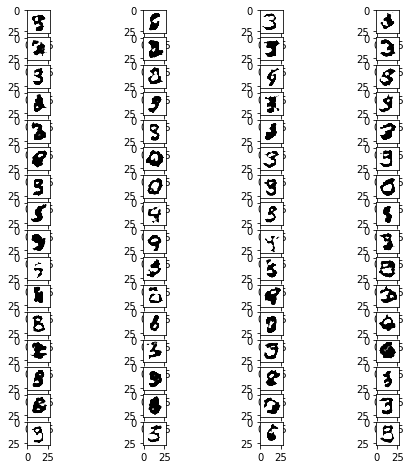

  0%|          | 1/937 [00:00<02:17,  6.82it/s]

--------------- Epoch 8 ---------------


100%|██████████| 937/937 [02:06<00:00,  7.42it/s]


D_loss = [0.29170796, 0.46875] ; G_loss = 5.3264503
(64, 28, 28, 1)


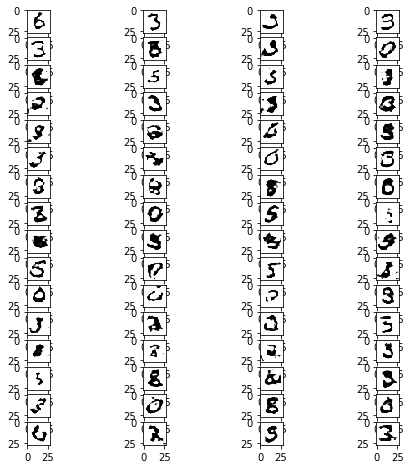

  0%|          | 1/937 [00:00<02:17,  6.82it/s]

--------------- Epoch 9 ---------------


100%|██████████| 937/937 [02:09<00:00,  7.22it/s]


D_loss = [0.20815375, 0.484375] ; G_loss = 5.2048264
(64, 28, 28, 1)


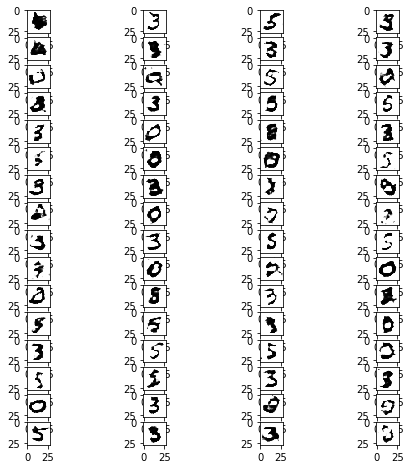

  0%|          | 1/937 [00:00<02:20,  6.64it/s]

--------------- Epoch 10 ---------------


100%|██████████| 937/937 [02:10<00:00,  7.17it/s]


D_loss = [0.24711901, 0.46875] ; G_loss = 3.532638
(64, 28, 28, 1)


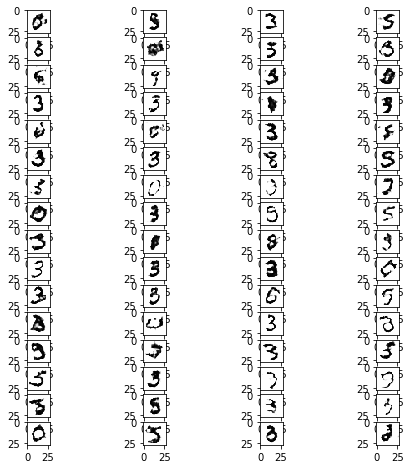

In [7]:
train_2D_gan("mnist", rand_param_size=100, epochs=10, batch_size=64, show_img=True)